#### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime
from sklearn.model_selection import KFold, GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к директориям и файлам. Загрузка данных

In [4]:
TRAIN_DATASET_PATH = '../cw/train.csv'
TEST_DATASET_PATH = '../cw/test.csv'

# загрузка данных
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [5]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [7]:
# изменение типа данных у категориальных признаков
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str) 

In [8]:
print('Размер тренировочного набора:', train_df.shape)
print('Размер тестового набора:', test_df.shape)

Размер тренировочного набора: (10000, 20)
Размер тестового набора: (5000, 19)


In [9]:
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

##### Целевая переменная

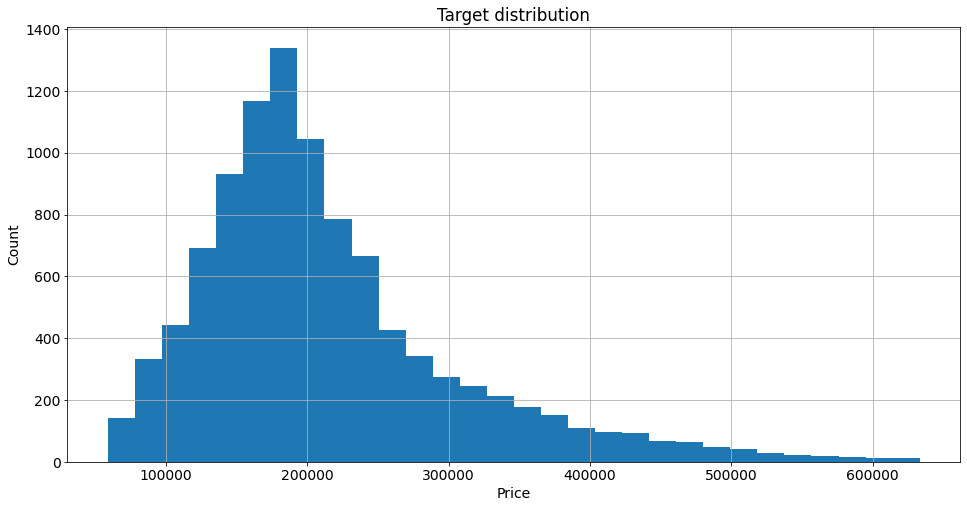

In [10]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(density=False, bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [11]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

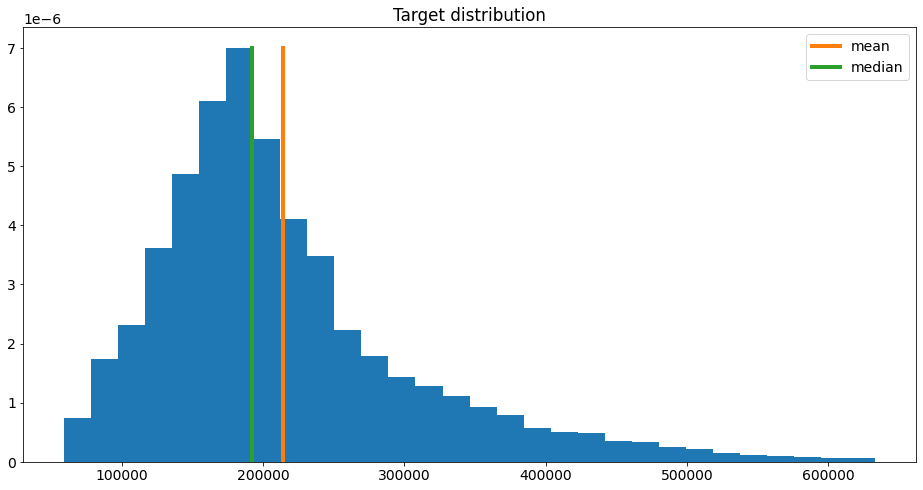

In [12]:
plt.figure(figsize = (16, 8))

plt.hist(train_df['Price'], density=True, bins=30)

y = np.linspace(0, 0.000007, 10)

plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)

plt.title('Target distribution')
plt.legend()
plt.show() 

##### Количественные признаки

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


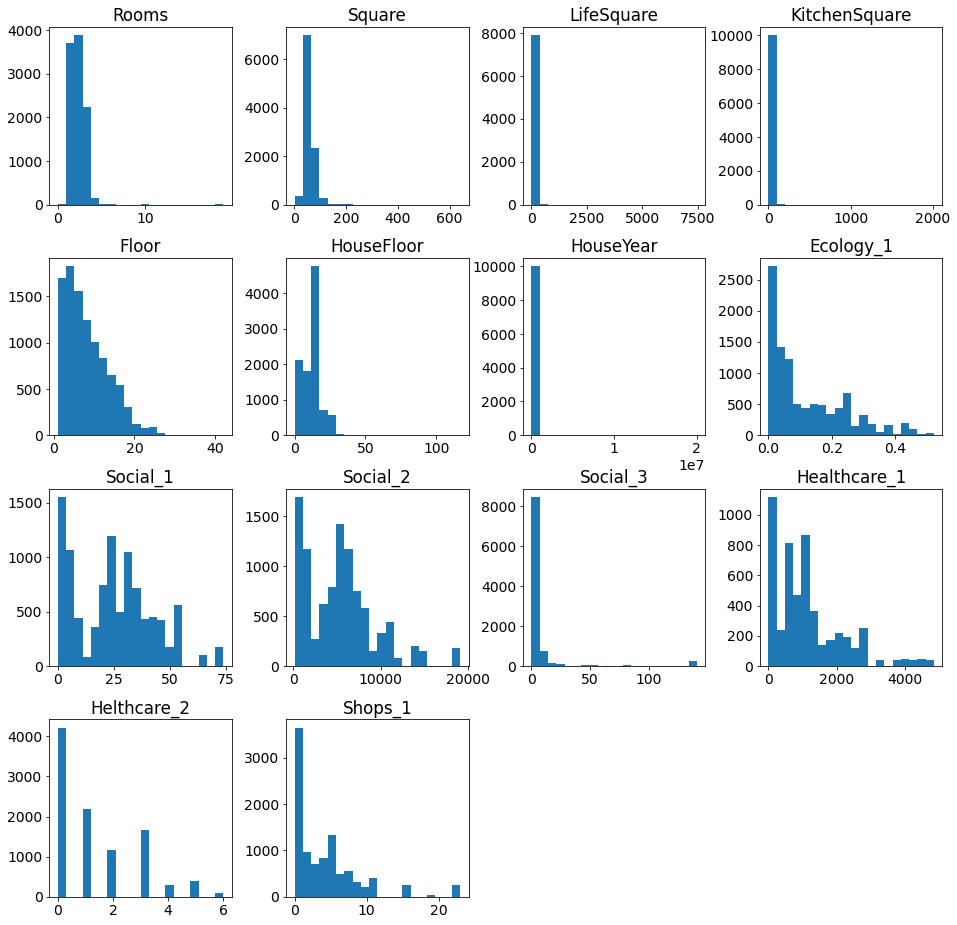

In [14]:
train_df_features = train_df.select_dtypes(include=['float64', 'int64'])

train_df_features.drop('Price', axis=1, inplace=True)

train_df_features.hist(figsize=(16,16), bins=20, grid=False);

##### Номинативные переменные

In [15]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [16]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
209      1
196      1
117      1
174      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [17]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [18]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [19]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

##### Взаимосвязь переменных

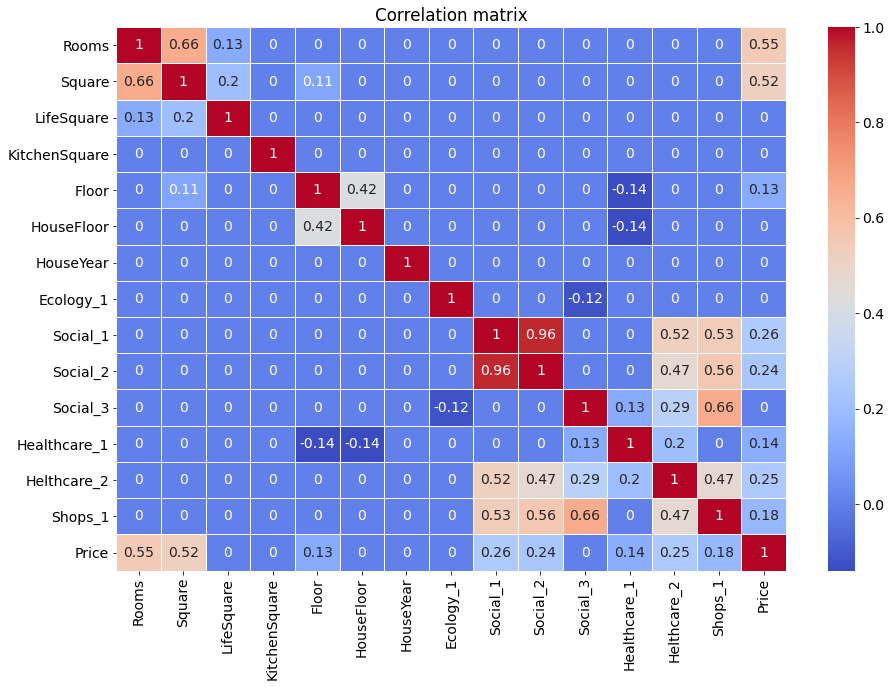

In [20]:
plt.figure(figsize = (15,10))

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Предобработка данных

#### 2. Обработка выбросов

###### - Rooms

In [21]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [22]:
# проставляем признак для нулевых значений Rooms или для значений больше или равно 6
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [23]:
# cреднее значение площади квартир в группировке по количеству комнат
train_df.groupby('Rooms').mean()['Square']

Rooms
0.0      81.620358
1.0      41.323277
2.0      56.788214
3.0      76.903234
4.0      98.377544
5.0     122.614941
6.0      59.414334
10.0     59.964120
19.0     42.006046
Name: Square, dtype: float64

In [24]:
# записываю в переменные среднюю площадь для квартир (1ком. - 5ком.)

two_room = train_df[train_df['Rooms'] == 2].mean()['Square']
three_room = train_df[train_df['Rooms'] == 3].mean()['Square']
four_room = train_df[train_df['Rooms'] == 4].mean()['Square']
five_room = train_df[train_df['Rooms'] == 5].mean()['Square']

# используя вышеуказанные переменные заполняю нулевые значения в столбце 'Rooms', 
# а так же значения >= 6 (учитывая данные о площади, имеющиеся в датасете) 

train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)) & (train_df['Square'] < two_room), 'Rooms'] = 1
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)) & ((two_room <= train_df['Square']) \
                                                    & (train_df['Square'] < three_room)), 'Rooms'] = 2
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)) & ((three_room <= train_df['Square']) \
                                                    & (train_df['Square'] < four_room)), 'Rooms'] = 3
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)) & ((four_room <= train_df['Square']) \
                                                    & (train_df['Square'] < five_room)), 'Rooms'] = 4
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)) & ((five_room <= train_df['Square']) \
                                            & (train_df['Square'] < (five_room + (five_room - four_room)))), 'Rooms'] = 5
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)) & ((five_room + (five_room - four_room)) \
                                                                      <= train_df['Square']), 'Rooms'] = 6


In [25]:
train_df.groupby('Rooms').mean()['Square']

Rooms
1.0     41.314582
2.0     56.790526
3.0     76.910140
4.0     98.377544
5.0    123.447192
6.0    212.932361
Name: Square, dtype: float64

In [26]:
train_df['Rooms'].value_counts()

2.0    3883
1.0    3710
3.0    2237
4.0     150
5.0      19
6.0       1
Name: Rooms, dtype: int64

##### Square

In [27]:
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [28]:
square_min_value = np.quantile(train_df['Square'], q=0.025)

square_min_value

32.10518291149681

In [29]:
# в датасете есть нереалистично минимальные значения площади квартир, для их корректировки решила отталкиваться от q=0.025
# и всё что меньше данного значения приравнивать к квантилю

train_df.loc[(train_df['Square'] < square_min_value), 'Square'] = square_min_value

train_df.loc[(train_df['Square']) > (train_df[train_df['Rooms'] == 6].mean()['Square']), 'Square'] \
                                                = train_df[train_df['Rooms'] == 6].mean()['Square']

In [30]:
train_df['Square'].describe()

count    10000.000000
mean        56.308129
std         19.116725
min         32.105183
25%         41.774881
50%         52.513310
75%         65.900625
max        212.932361
Name: Square, dtype: float64

###### - KitchenSquare

In [31]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [32]:
# для заполнения нулевых значений площади кухни, а так же значений превышающих площадь всей квартиры
# решила ориентироваться на 20% от общей площади квартиры

train_df.loc[(train_df['KitchenSquare'] == 0) | (train_df['KitchenSquare'] > train_df['Square']), 'KitchenSquare'] \
                                                                                          = train_df['Square'] * 0.2

# всё что меньше 4 кв.метров приравниваю к 20% от общей площади

train_df.loc[train_df['KitchenSquare'] < 4, 'KitchenSquare'] = train_df['Square'] * 0.2

# чтобы подчистить высокие значения площади кухни, решила за 'потолок' площади взять 50 % от общей площади квартиры
# (основываясь на предположении, что в однокомнатных кухня может занимать до 50 % площади). 
# Данные отфильтрованные по такому признаку приравниваю к 20% от общей площади. 

train_df.loc[train_df['KitchenSquare'] > (train_df['Square'] * 0.5), 'KitchenSquare'] = train_df['Square'] * 0.2

In [33]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         9.302743
std          3.647053
min          4.000000
25%          7.000000
50%          8.775388
75%         10.841121
max         43.000000
Name: KitchenSquare, dtype: float64

##### HouseFloor, Floor

In [34]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [35]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [36]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [37]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [38]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [39]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [40]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

##### HouseYear

In [41]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [42]:
train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

#### 3. Обработка пропусков

In [43]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [44]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.000000
1,39.832524,23.169223,8.000000
2,78.342215,47.671972,10.000000
3,40.409907,NaN,8.081981
4,64.285067,38.562517,9.000000
5,62.528465,47.103833,6.000000
6,33.938750,21.772930,9.000000
7,50.391814,32.893256,8.000000
8,46.887892,44.628132,9.377578
9,79.867477,75.085125,15.973495


##### LifeSquare

In [45]:
# количество строк в которых 'LifeSquare' больше 'Square'
(train_df['LifeSquare'] > train_df['Square']).sum()

464

In [46]:
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [47]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) & (~train_df['KitchenSquare'].isna())

# для расчета жилой площади использую разность между 'Square', 'KitchenSquare' и 10% от общей площади

train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] \
                                                             - (train_df.loc[condition, 'Square'] * 0.1)

# использую аналогичный способ для корректировки 'LifeSquare' > 'Square'

train_df.loc[(train_df['LifeSquare'] > train_df['Square']) | ((train_df['LifeSquare'] + train_df['KitchenSquare']) \
            > train_df['Square']), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'] - train_df['Square'] * 0.1

In [48]:
(train_df['LifeSquare'] > train_df['Square']).sum()

0

In [49]:
train_df['LifeSquare'].isna().sum()

0

In [50]:
# т.к. есть минимальные значения LifeSquare (1, 2 или 0.3 кв.м), то хочется немного их подправить. 
# сложно понять какую цифру принимать за минимальное значение, поэтому буду ориентироваться на уже полюбившийся q=0.025

ls_min_value = np.quantile(train_df['LifeSquare'], q=0.025)

ls_min_value

15.146123972262354

In [51]:
# теперь значения LifeSquare < q=0.025 можно приравнять к данному минимальному значению
train_df.loc[train_df['LifeSquare'] < ls_min_value, 'LifeSquare'] = ls_min_value

In [52]:
train_df['LifeSquare'].describe()

count    10000.000000
mean        35.587241
std         14.211743
min         15.146124
25%         24.410574
50%         32.782779
75%         44.802382
max        181.639125
Name: LifeSquare, dtype: float64

##### Healthcare_1

In [53]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [54]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.square_min_quantile = None
        self.square_max_quantile = None
        self.lifesquare_quantile = None
        self.two_room = None
        self.three_room = None
        self.four_room = None
        self.five_room = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.square_min_quantile = X['Square'].quantile(.025)
        self.square_max_quantile = X['Square'].quantile(.975)
        self.lifesquare_quantile = X['LifeSquare'].quantile(.025)
        self.two_room = X[X['Rooms'] == 2].mean()['Square']
        self.three_room = X[X['Rooms'] == 3].mean()['Square']
        self.four_room = X[X['Rooms'] == 4].mean()['Square']
        self.five_room = X[X['Rooms'] == 5].mean()['Square']
        
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        

        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)) & (X['Square'] < self.two_room), 'Rooms'] = 1
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)) & ((self.two_room <= X['Square']) \
                                                         & (X['Square'] < self.three_room)), 'Rooms'] = 2
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)) & ((self.three_room <= X['Square']) \
                                                         & (X['Square'] < self.four_room)), 'Rooms'] = 3
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)) & ((self.four_room <= X['Square']) \
                                                         & (X['Square'] < self.five_room)), 'Rooms'] = 4
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)) & ((self.five_room <= X['Square']) & (X['Square'] \
                                            < (self.five_room + (self.five_room - self.four_room)))), 'Rooms'] = 5
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] >= 6)) & ((self.five_room + (self.five_room - self.four_room)) \
                                                         <= X['Square']), 'Rooms'] = 6
 
     
        # Square

        X.loc[X['Square'] < self.square_min_quantile, 'Square'] = self.square_min_quantile

        X.loc[(X['Square']) > (X[X['Rooms'] == 6].mean()['Square']), 'Square'] = X[X['Rooms'] == 6].mean()['Square']
        
        # KitchenSquare
        
        # для заполнения нулевых значений площади кухни решила ориентироваться на 20% от общей площади квартиры
        X.loc[(X['KitchenSquare'] == 0) | (X['KitchenSquare'] > X['Square']), 'KitchenSquare'] = X['Square'] * 0.2
        
        # значения меньше 4 кв.м приравниваю к 20% от общей площади
        X.loc[X['KitchenSquare'] < 4, 'KitchenSquare'] = X['Square'] * 0.2
        
        # чтобы подчистить максимальные значения площади кухни, решила за 'потолок' площади взять 50 % от обшей площади
        X.loc[X['KitchenSquare'] > (X['Square'] * 0.5), 'KitchenSquare'] = X['Square'] * 0.2
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] \
                                                                   - (X.loc[condition, 'Square'] * 0.1)
        
        X.loc[(X['LifeSquare'] > X['Square']) | ((X['LifeSquare'] + X['KitchenSquare']) > X['Square']), 'LifeSquare'] \
                    = X['Square'] - X['KitchenSquare'] - train_df['Square'] * 0.1
       
    
        X.loc[X['LifeSquare'] < self.lifesquare_quantile, 'LifeSquare'] = self.lifesquare_quantile
        
        X.fillna(self.medians, inplace=True)
           
        
        return X

#### 4. Построение новых признаков

##### Ecology

In [55]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

##### DistrictSize, IsDistrictLarge

In [56]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [57]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,93.524580,10.000000,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.871089,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,28.286935,8.081981,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.007630,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,0,0,89


In [58]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [59]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

##### MedPriceByFloorYear

In [60]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [61]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [62]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [63]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,year_cat,floor_cat
0,11809,27,3.0,115.027311,93.524580,10.000000,4,10.0,2014,0.075424,...,0,1,305018.871089,0,0,1,851,1,6,2
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,0,1,177734.553407,0,0,0,78,0,3,3
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,1,1,282078.720850,0,0,0,652,1,4,1
3,2352,1,1.0,40.409907,28.286935,8.081981,10,22.0,1977,0.007122,...,1,1,168106.007630,0,0,1,652,1,3,4
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,6,1,343995.102962,0,0,0,89,0,3,5


In [64]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,371528.963166
1,1,2,324303.812481
2,1,3,429090.881284
3,1,4,274992.472366
4,2,1,467230.539057


In [65]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,93.524580,10.000000,4,10.0,2014,0.075424,...,1,305018.871089,0,0,1,851,1,6,2,162124.189453
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,1,177734.553407,0,0,0,78,0,3,3,192711.526271
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,1,282078.720850,0,0,0,652,1,4,1,201895.819112
3,2352,1,1.0,40.409907,28.286935,8.081981,10,22.0,1977,0.007122,...,1,168106.007630,0,0,1,652,1,3,4,183445.443721
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,1,343995.102962,0,0,0,89,0,3,5,173945.210796


In [66]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
    
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

##### 5. Отбор признаков

In [67]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [68]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge', 'MedPriceByFloorYear']

target_name = 'Price'

In [69]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [71]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [72]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 28), (3300, 28), (5000, 28))

In [73]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [74]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

#### 7. Построение модели

##### Обучение

In [75]:
gbr_model = GradientBoostingRegressor(random_state=42,
                                n_estimators=120,
                                min_samples_leaf=8,
                                max_depth=10,
                                max_leaf_nodes=10)


gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=10, max_leaf_nodes=10, min_samples_leaf=8,
                          n_estimators=120, random_state=42)

##### Оценка модели

Train R2:	0.808
Test R2:	0.747


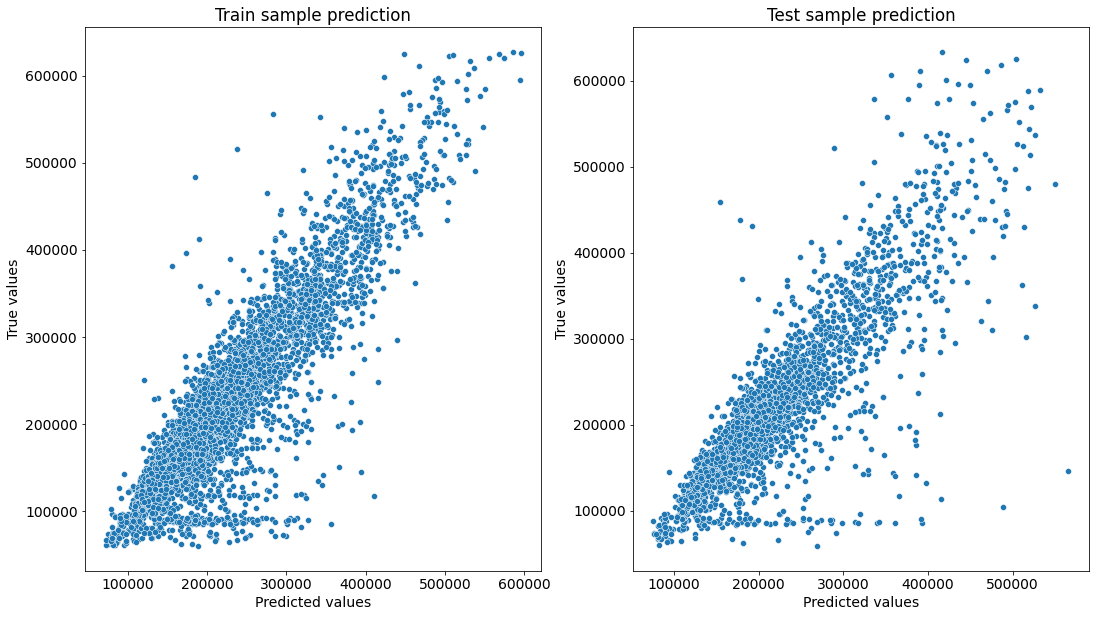

In [76]:
y_train_preds = gbr_model.predict(X_train)
y_test_preds = gbr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

##### Кросс-валидация

In [77]:
cv_score_2 = cross_val_score(gbr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score_2

array([0.73105648, 0.69029141, 0.72547999])

In [78]:
cv_score_2.mean()

0.715609296087314

##### Важность признаков

In [79]:
feature_importances = pd.DataFrame(zip(X_train.columns, gbr_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.464779
20,DistrictSize,0.231440
12,Social_3,0.056880
11,Social_2,0.047299
0,Rooms,0.036988
7,Ecology_1,0.031884
10,Social_1,0.025491
23,MedPriceByFloorYear,0.020034
6,HouseYear,0.017444
5,HouseFloor,0.015562


#### 8. Прогнозирование на тестовом датасете

In [80]:
test_df.shape

(5000, 24)

In [81]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.000000,5,9.0,1970,0.036122,1,1,...,1,1,0,0,0,0,76.0,0,0,188148.675311
1,1.0,42.493907,28.510655,10.000000,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,0,164.0,0,1,178457.328730
2,2.0,59.463678,44.517310,9.000000,19,19.0,1977,0.211401,1,1,...,1,1,0,0,0,1,580.0,0,1,174339.691014
3,3.0,49.646030,33.893825,6.000000,2,2.0,1965,0.014073,1,1,...,0,1,0,0,0,0,372.0,0,1,180344.164153
4,1.0,53.837056,37.685939,10.767411,8,17.0,1977,0.309479,1,1,...,6,1,0,0,0,1,65.0,0,0,193048.911892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.000000,5,5.0,1962,0.069660,1,1,...,2,1,0,1,0,0,56.0,0,0,188148.675311
4996,3.0,93.698122,71.237997,10.000000,21,27.0,2018,0.060753,1,1,...,7,1,0,0,0,0,26.0,0,0,201323.139697
4997,1.0,33.656723,19.003259,5.000000,2,5.0,1966,0.038693,1,1,...,5,1,0,0,0,0,54.0,0,0,180344.164153
4998,1.0,38.635155,20.976257,9.000000,8,14.0,1970,0.089040,1,1,...,11,1,0,0,0,0,40.0,0,0,193048.911892


In [82]:
submit = pd.read_csv('../cw/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [83]:
predictions = gbr_model.predict(test_df)
predictions

array([168264.76252211, 127667.02142199, 152964.02935661, ...,
       146070.24222621, 193615.45139516, 238491.70839224])

In [84]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,168264.762522
1,5925,127667.021422
2,960,152964.029357
3,3848,127825.825062
4,746,210721.594103


In [85]:
submit.to_csv('rf_submit.csv', index=False)